In [22]:
import pandas as pd
import numpy as np
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
# 구글 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# GroundTruth.csv 파일 읽기
ground_truth = pd.read_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/GroundTruth.csv')

# NewGroundTruth.csv를 생성하기 위한 데이터 저장
new_data = []

In [12]:
# 기존 데이터셋
ground_truth

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# RLE 인코딩 함수
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [5]:
# 각 이미지에 대해 처리
for index, row in ground_truth.iterrows():
    image_name = row['image']
    class_name = None

    # Class 이름 찾기
    for class_type in ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']:
        if row[class_type] == 1:
            class_name = class_type
            break

    # 이미지와 마스크 파일 경로
    image_path = f'/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images/{image_name}.jpg'
    mask_path = f'/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/masks/{image_name}_segmentation.png'

    # 마스크 이미지 읽기
    mask_image = imread(mask_path, as_gray=True)

    # 마스크 이미지 바이너리화 (이진화)
    mask_image = (mask_image > 0).astype(np.uint8)

    # RLE 인코딩
    encoded_pixels = rle_encode(mask_image)

    # 데이터 저장
    new_data.append([image_name, class_name, encoded_pixels])

In [6]:
# 새로운 DataFrame 생성
new_ground_truth = pd.DataFrame(new_data, columns=['Image', 'Class', 'EncodedPixels'])

# NewGroundTruth.csv 파일로 저장
new_ground_truth.to_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/NewGroundTruth.csv', index=False)

print("NewGroundTruth.csv 파일이 생성되었습니다.")

NewGroundTruth.csv 파일이 생성되었습니다.


In [9]:
# 파일 불러와서 출력
new_ground_truth = pd.read_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/NewGroundTruth.csv')

In [10]:
new_ground_truth

,Image,Class,EncodedPixels
0,ISIC_0024306,NV,4523 31 5117 39 5713 46 6311 49 6907 54 7505 5...
1,ISIC_0024307,NV,20742 18 21339 24 21937 30 22535 35 23134 39 2...
2,ISIC_0024308,NV,39740 7 40339 11 40938 15 41537 18 42137 20 42...
3,ISIC_0024309,NV,69112 9 69709 15 70305 21 70901 27 71499 30 72...
4,ISIC_0024310,MEL,47094 20 47692 24 48290 28 48888 33 49487 36 5...
...,...,...,...
10010,ISIC_0034316,MEL,50578 38 51176 47 51773 54 52371 58 52969 61 5...
10011,ISIC_0034317,MEL,73500 9 74097 19 74695 24 75292 30 75889 39 76...
10012,ISIC_0034318,BKL,54936 8 55527 47 56119 67 56711 80 57307 89 57...
10013,ISIC_0034319,NV,69900 11 70494 19 71090 25 71686 30 72284 33 7...


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 클래스별로 데이터 분할을 위한 딕셔너리 생성
train_data = pd.DataFrame(columns=new_ground_truth.columns)
valid_data = pd.DataFrame(columns=new_ground_truth.columns)
test_data = pd.DataFrame(columns=new_ground_truth.columns)

# 각 클래스를 8:1:1 비율로 나누기
for class_type in new_ground_truth['Class'].unique():
    class_data = new_ground_truth[new_ground_truth['Class'] == class_type]

    # 8:1:1 비율로 나누기
    train, temp = train_test_split(class_data, test_size=0.2, random_state=42)
    valid, test = train_test_split(temp, test_size=0.5, random_state=42)

    # 나눈 데이터를 각각 저장
    train_data = pd.concat([train_data, train], ignore_index=True)
    valid_data = pd.concat([valid_data, valid], ignore_index=True)
    test_data = pd.concat([test_data, test], ignore_index=True)


In [21]:
# 파일로 저장
train_data.to_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/TrainData.csv', index=False)
valid_data.to_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/ValidData.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset//TestData.csv', index=False)

print("데이터셋이 성공적으로 분할되고 저장되었습니다.")

데이터셋이 성공적으로 분할되고 저장되었습니다.


<ipython-input-24-41934db9062d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(train_counts.index, rotation=45)
<ipython-input-24-41934db9062d>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(valid_counts.index, rotation=45)
<ipython-input-24-41934db9062d>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(test_counts.index, rotation=45)


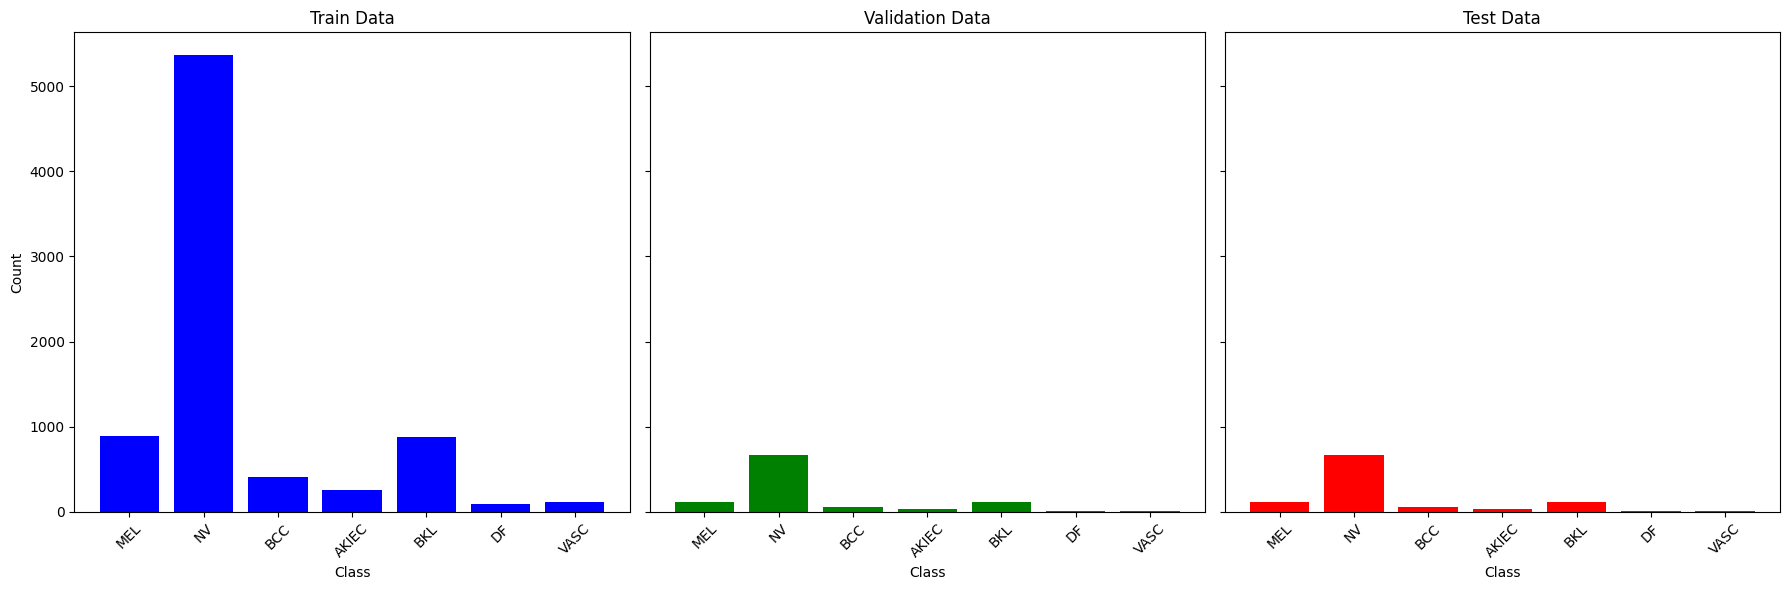

In [24]:
# 클래스 리스트
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# 클래스별 개수 세기
train_counts = train_data['Class'].value_counts().reindex(classes, fill_value=0)
valid_counts = valid_data['Class'].value_counts().reindex(classes, fill_value=0)
test_counts = test_data['Class'].value_counts().reindex(classes, fill_value=0)

# Plot 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Train Data
axes[0].bar(train_counts.index, train_counts.values, color='blue')
axes[0].set_title('Train Data')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Class')
axes[0].set_xticklabels(train_counts.index, rotation=45)

# Valid Data
axes[1].bar(valid_counts.index, valid_counts.values, color='green')
axes[1].set_title('Validation Data')
axes[1].set_xlabel('Class')
axes[1].set_xticklabels(valid_counts.index, rotation=45)

# Test Data
axes[2].bar(test_counts.index, test_counts.values, color='red')
axes[2].set_title('Test Data')
axes[2].set_xlabel('Class')
axes[2].set_xticklabels(test_counts.index, rotation=45)

plt.tight_layout()
plt.show()

In [19]:
print(train_data[train_data['Class'] == 'VASC'].shape[0])
print(valid_data[valid_data['Class'] == 'VASC'].shape[0])
print(test_data[test_data['Class'] == 'VASC'].shape[0])

113
14
15


In [20]:
print(train_data[train_data['Class'] == 'NV'].shape[0])
print(valid_data[valid_data['Class'] == 'NV'].shape[0])
print(test_data[test_data['Class'] == 'NV'].shape[0])

5364
670
671
